# Flat Plate with Structural Aerodynamic Load

In this example, we present an illustrative case where a flat plate rotates while being subjected to a rotational spring moment and damper as well as aerodynamic loads. The structural dynamics are modeled by a torsional spring–mass–damper ODE driven by the aerodynamic pitching moment $\tau_y(t)$:

$$
I\,\ddot{\theta}(t) + 2\,\zeta\,\omega_N\,I\,\dot{\theta}(t) + K\bigl(\theta(t)-\theta_0\bigr) = \tau_y(t).
$$

As you can see below, the flat-plate mesh consists of two zones separated by a circular sliding interface. The inner zone will rotate while the outer zone remains stationary. This is the same mesh topology as what is used for rotating propeller simulations.

![UDD mesh flat plate](figures/flat_plate_UDD_tutorial_mesh.png)

## 1. Imports and Create Project

In this section we:
- **Import Flow360 and NumPy**: `flow360` provides the high-level Python API for setting up and running the CFD case, while `numpy` is used for basic math and unit handling.
- **Load the flat-plate mesh**: the CGNS file `rotatingPlate.cgns` is uploaded to the Flow360 platform and becomes the basis of the `Project`.
- **Create a** `Project` **and** `VolumeMesh` **handle**: `Project.from_volume_mesh(mesh)` creates (or reuses) a project on the server, and `vm = project.volume_mesh` gives convenient access to mesh blocks and boundary entities used later for BCs and UDD setup.

In [1]:
import flow360 as fl
from flow360.examples import TutorialUDDStructural
import numpy as np

TutorialUDDStructural.get_files()
project = fl.Project.from_volume_mesh(
    TutorialUDDStructural.mesh_filename, name="UDD structural tutorial from Python"
)
vm = project.volume_mesh

Output()

Output()

[18:39:40] INFO: VolumeMesh successfully submitted:                                                                
                   type        = Volume Mesh                                                                       
                   name        = UDD structural tutorial from Python                                               
                   id          = vm-b11bca1f-a264-487c-8f1a-eeb168096f2c                                           
                   status      = uploaded                                                                          
                   project id  = prj-50ef37d8-4b77-480e-92c1-98a68f613176                                          
           

Output()

## 2. Operating Conditions

Since the mesh flat plate length is different from experiment, the operating conditions are computed based on a reference Mach number and reference Reynolds number.

More precisely, the code below:
- **Defines experimental reference values**: freestream velocity, reference length, density, temperature, and kinematic viscosity are specified in SI units using Flow360’s unit helpers.
- **Computes Mach and Reynolds numbers**: `Mach` is derived from `u_inf` and the speed of sound; `Reynolds` is based on the experiment reference length and kinematic viscosity.
- **Maps to mesh units**: `Re_mesh_unit` rescales the Reynolds number to the mesh length scale so the simulation matches the intended experimental conditions.
- **Creates an** `AerospaceCondition`: `operating_condition = fl.AerospaceCondition.from_mach_reynolds(...)` packages these quantities into a reusable object for the solver.

In [2]:
# Experiment reference values in SI unit system
u_inf = 15 * fl.u.m / fl.u.s
ref_length = (4 * fl.u.inch).to("m")
ref_density = 1.226 * fl.u.kg / fl.u.m**3
ref_T = 288.15 * fl.u.K
kinematic_viscosity = 14.61e-6 * fl.u.m**2 / fl.u.s

R = 287.058 * fl.u.J / (fl.u.kg * fl.u.K)
speed_of_sound = np.sqrt(1.4 * R * ref_T).to("m/s")
Mach = u_inf / speed_of_sound
Reynolds = u_inf * ref_length / kinematic_viscosity

# Define operating condition based on reference values
mesh_unit = project.length_unit
Re_mesh_unit = Reynolds * mesh_unit.to_value() / ref_length
operating_condition = fl.AerospaceCondition.from_mach_reynolds(
    mach=Mach,
    reynolds_mesh_unit=Re_mesh_unit,
    project_length_unit=project.length_unit,
)

[18:39:58] INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

## 2. Boundary Conditions and Rotating Interfaces

The following cell defines how the flow interacts with the flat plate and how the inner plate region is allowed to rotate:
- **Freestream and walls**: `Freestream` is applied on the far-field block, `SlipWall` on non-plate walls, and `Wall` (no-slip) on the plate itself.
- **Rotating volume**: `volume_rotation = vm["plateBlock"]` selects the inner block that will move as a rigid body around the specified axis.
- **Rotation model**: `fl.Rotation(..., spec=fl.FromUserDefinedDynamics())` tells Flow360 that the rotational motion will be driven by a User Defined Dynamic (UDD) law defined later, rather than by a prescribed constant rate. The UDD will specify $\dot{\omega}$, $\omega$, and $\theta$ for each physical step.

In [3]:
# Boundary Conditions
freestream = fl.Freestream(entities=vm["farFieldBlock/farField"])
slip_wall = fl.SlipWall(entities=vm["*/slipWall"])
no_slip_wall = fl.Wall(entities=vm["plateBlock/noSlipWall"])
BCs = [freestream, slip_wall, no_slip_wall]

# Rotating zones
volume_rotation = vm["plateBlock"]
volume_rotation.center = (0, 0, 0) * fl.u.m
volume_rotation.axis = [0, 1, 0]
rotation_model = fl.Rotation(
    entities=[volume_rotation], spec=fl.FromUserDefinedDynamics()
)

## 3. Couple Structural Model

The dynamics of the plate will be influenced by the spring and damper according to this law:

$$
\dot{\omega}(t) = \frac{\tau_y(t) - K\,(\theta(t) - \theta_0) - 2\,\zeta\,\omega_N\,I\,\omega(t)}{I}
$$

$$
\omega(t) - \omega_0 = \int_0^t \dot{\omega}(t') \, dt'
$$

$$
\theta(t) - \theta_0 = \int_0^t \omega(t') \, dt'
$$

| Symbol | Description |
|--------|-------------|
| $\theta$ | Rotation angle of the plate in radians. |
| $\omega$ | Rotation velocity of the plate in radians. |
| $\dot{\omega}$ | Rotation acceleration of the plate in radians. |
| $\tau_y$ | Aerodynamic moment exerted on the plate. |
| $K$ | Stiffness of the spring attached to the plate at the structural support. |
| $\zeta$ | Structural damping ratio. |
| $\omega_N$ | Structural natural angular frequency. |
| $I$ | Structural moment of inertia. |

In the next few cells we will:
- **Specify numerical values** for the structural parameters ($I, \zeta, K, \omega_N, \theta_0$) and initial conditions for $\theta$ and $\dot{\omega}$.
- **Set the time step and number of steps** so that the structural oscillations are resolved in time.
- **Encode this ODE system as a User Defined Dynamic** in Flow360, which takes the aerodynamic moment $\tau_y$ as input and outputs the plate rotation state used by the mesh motion model.


### 3.1 Define Model Constants

Here we choose the numerical values that define the torsional spring–mass–damper model of the plate:
- $I$: structural moment of inertia of the rotating plate about its hinge axis.
- $\zeta$: non-dimensional structural damping ratio; smaller values lead to slowly decaying oscillations.
- $\theta_0$: equilibrium pitch angle about which the spring tries to restore the plate.
- `iniPert`: initial perturbation added on top of $\theta_0$, which directly sets the initial oscillation amplitude.
- $K$ and $\omega_N$: linear torsional stiffness and corresponding natural frequency, related approximately by $\omega_N = \sqrt{K/I}$.
- `initTheta` and `initOmegaDot`: initial angle and angular acceleration used to initialize the UDD state vector for the first physical time step.

In [4]:
deg2rad = np.pi / 180

I = 0.443768309310345  # Structural moment of inertia
zeta = 0.005  # Structural damping ratio
theta0 = 5 * deg2rad  # Initial equilibrium angle
iniPert = 45 * deg2rad  # Initial perturbation
K = 0.005  # Stiffness of the spring
omegaN = np.sqrt(K / I)  # Structural natural angular frequency
initTheta = theta0 + iniPert
initOmegaDot = (0 - K * (initTheta - theta0)) / I

### 3.2 Define Time Settings

The next cell configures the unsteady time marching for the coupled aeroelastic simulation:
- `deltaNonDimensional`: a non-dimensional time step size, scaled by the acoustic time based on `ref_length / speed_of_sound`.
- `delta_SI`: the corresponding physical time step in seconds, passed to the solver as `step_size`.
- `n_steps`: total number of physical steps to march the coupled flow–structure system.
- `fl.Unsteady(...)`: creates a time stepping object that controls the outer physical time loop and the number of inner pseudo-steps used to converge each time level.

In [5]:
deltaNonDimensional = 0.5
delt_SI = deltaNonDimensional * (ref_length / speed_of_sound)
n_steps = 3000
time_stepping = fl.Unsteady(
    max_pseudo_steps=100,
    step_size=delt_SI,
    steps=n_steps,
)

### 3.3 UDD for structural solver

This User Defined Dynamic (UDD) encodes the structural ODE and couples it to the CFD solution:
- **Inputs**: `momentY` is the aerodynamic pitching moment from the wall patch on the plate.
- **Constants**: the structural parameters (`I`, `zeta`, `K`, `omegaN`, `theta0`) are passed in once and reused each step.
- **Output Vars**: the state vector `state[0:3]` stores $\dot{\omega}$, $\omega$, and $\theta$; these are exposed as `omegaDot`, `omega`, and `theta` outputs. It is important to use this names since the values of $\dot{\omega}$, $\omega$, and $\theta$ will be updated for `state[0:3]` for each physical step, this will drive the rotation of the sliding interface.
- **Initial values**: `state_vars_initial_value` initializes the ODE with `initOmegaDot` and `initTheta` from Section 3.1.
- **Update law**: for each physical step (`pseudoStep == 0`), the first expression integrates $\dot{\omega}$, the second integrates $\omega$, and the third integrates $\theta$ using an explicit Euler update with `timeStepSize`.
- **Coupling to motion**: `output_target=vm["plateBlock"]` sends the updated `theta` back to the rotating volume, which the rotation model uses to move the mesh.

In [6]:
dynamic = fl.UserDefinedDynamic(
    name="dynamicTheta",
    input_vars=["momentY"],
    constants={
        "I": I,
        "zeta": zeta,
        "K": K,
        "omegaN": omegaN,
        "theta0": theta0,
    },
    output_vars={
        "omegaDot": "state[0];",
        "omega": "state[1];",
        "theta": "state[2];",
    },
    state_vars_initial_value=[str(initOmegaDot), "0.0", str(initTheta)],
    update_law=[
        "if (pseudoStep == 0) (momentY - K * ( state[2] - theta0 ) - 2 * zeta * omegaN * I *state[1] ) / I; else state[0];",
        "if (pseudoStep == 0) state[1] + state[0] * timeStepSize; else state[1];",
        "if (pseudoStep == 0) state[2] + state[1] * timeStepSize; else state[2];",
    ],
    input_boundary_patches=vm["plateBlock/noSlipWall"],
    output_target=vm["plateBlock"],
)

## 4. Outputs

We will put some slice outptus to have a time visualisation of the flowfield.

The code below configures what Flow360 writes during the run:
- `SliceOutput`: extracts a 2D slice at $y=0$ (normal to the $y$ axis) at selected time steps, outputting primitive variables and Mach number in Tecplot format.
- `VolumeOutput`: writes 3D volume fields (primitive variables, $Q$-criterion, and Mach number) for full-flow visualization.
- **Output frequency**: `frequency` and `frequency_offset` control how often and when in the run the slice output is written, so that the transient behavior of the oscillating plate can be visualized efficiently.

In [7]:
with fl.SI_unit_system:
    outputs = [
        fl.SliceOutput(
            slices=[fl.Slice(name="y-slice", origin=(0, 0, 0), normal=(0, 1, 0))],
            output_format="tecplot",
            output_fields=["primitiveVars", "Mach"],
            frequency=10,
            frequency_offset=200,
        ),
        fl.VolumeOutput(
            output_format="tecplot",
            output_fields=["primitiveVars", "qcriterion", "Mach"],
        ),
    ]

           INFO: using: SI unit system for unit inference.

## 5. Simulation Parameters

The previous defined settings are used here to define the `SimulationParams`.

Specifically, this section:
- **Defines a reference geometry**: sets the aerodynamic reference moment center, length, and area used to non-dimensionalize forces and moments.
- **Attaches the operating condition and time stepping**: `operating_condition` and `time_stepping` from earlier sections are plugged into the top-level parameters.
- **Configures fluid and turbulence solvers**: creates a `NavierStokesSolver` and `SpalartAllmaras` turbulence model with tolerances, linear solver controls, and accuracy/order settings tailored to this case.
- **Adds models and BCs**: combines all boundary conditions, the rotation model, and the User Defined Dynamic into the list of active models.
- **Registers outputs**: passes the `outputs` list so that slice and volume data are produced according to the configuration in Section 4.

In [8]:
with fl.SI_unit_system:
    param = fl.SimulationParams(
        reference_geometry=fl.ReferenceGeometry(
            moment_center=(0, 0, 0),
            moment_length=(1, 1, 1) * mesh_unit,
            area=0.5325 * mesh_unit * mesh_unit,
        ),
        operating_condition=operating_condition,
        time_stepping=time_stepping,
        models=[
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(
                    absolute_tolerance=1e-9,
                    relative_tolerance=1e-3,
                    linear_solver=fl.LinearSolver(max_iterations=35),
                    kappa_MUSCL=0.33,
                    order_of_accuracy=2,
                    update_jacobian_frequency=1,
                    equation_evaluation_frequency=1,
                    low_mach_preconditioner=True,
                ),
                turbulence_model_solver=fl.SpalartAllmaras(
                    absolute_tolerance=1e-8,
                    relative_tolerance=1e-2,
                    linear_solver=fl.LinearSolver(max_iterations=35),
                    order_of_accuracy=2,
                    rotation_correction=True,
                    update_jacobian_frequency=1,
                    reconstruction_gradient_limiter=0.5,
                    equation_evaluation_frequency=1,
                ),
            ),
            *BCs,
            rotation_model,
        ],
        outputs=outputs,
        user_defined_dynamics=[dynamic],
    )

           INFO: using: SI unit system for unit inference.

## 6. Run Case

Here we finally submit the configured simulation to Flow360:
- `project.run_case(param)`: packages the mesh, models, operating condition, and solver settings into a `Case` and sends it to the server.
- `case`: can be used to monitor status, wait for completion, and fetch results (as done in the post-processing section).

In [9]:
case = project.run_case(params=param, name="UDD structural tutorial from Python")

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

           INFO: using: SI unit system for unit inference.

[18:40:00] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = UDD structural tutorial from Python                                               
                   id          = case-cb351231-8428-4b41-8e00-a00cb4c9c61c                                         
                   status      = pending                                                                           
                   project id  = prj-50ef37d8-4b77-480e-92c1-98a68f613176                                          
           

## 7. Post Processing

Once the case has finished, we read back and visualize key integrated quantities from the server-side results:
- **Wait for completion**: `case.wait()` blocks until the CFD run finishes.
- **Total forces**: `results.total_forces.as_dataframe()` returns time histories of lift and drag coefficients (`CL`, `CD`), which are plotted versus `physical_step` to show the plate’s oscillatory response.
- **Nonlinear residuals**: `results.nonlinear_residuals` exposes solver convergence histories (continuity, momentum, energy, and turbulence variable), plotted on a log scale to verify converge. The data is filtered to show only the last pseudo step using `filter_physical_steps_only`.

Output()

Output()

[18:58:49] INFO: Saved to /tmp/tmpbfsct6q_/8f1619f2-d54b-48c7-b87b-c4b1cd54fa42.csv

Output()

[18:58:51] INFO: Saved to /tmp/tmpbfsct6q_/2715dda5-2f01-4200-a74c-b33fbb253b90.csv

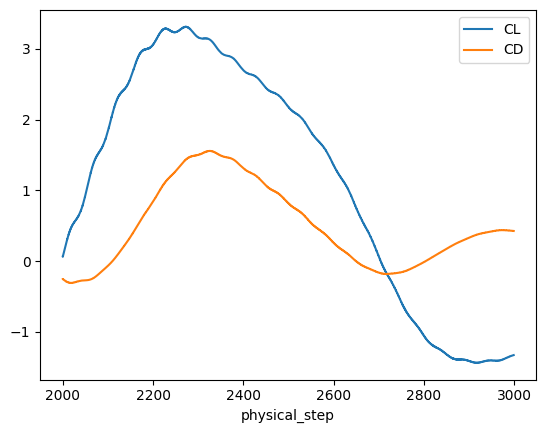

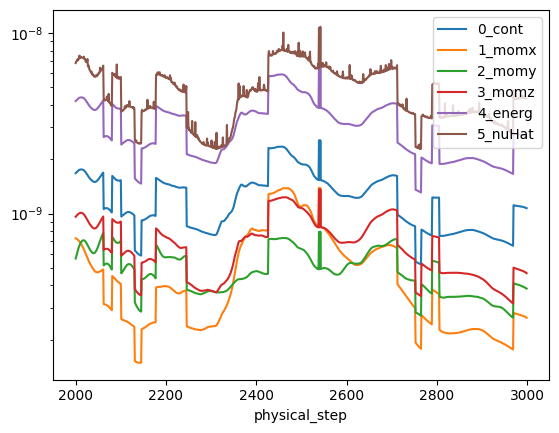

In [10]:
import matplotlib.pyplot as plt

case.wait()

results = case.results

total_forces = results.total_forces.as_dataframe()
total_forces_2000 = total_forces[total_forces["physical_step"] >= 2000]
total_forces_2000.plot("physical_step", ["CL", "CD"])

non_linear = results.nonlinear_residuals
non_linear.filter_physical_steps_only()
non_linear = non_linear.as_dataframe()
non_linear_2000 = non_linear[non_linear["physical_step"] >= 2000]
non_linear_2000.plot(
    "physical_step",
    ["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
)

plt.show()

![v field](figures/flat_plate_v.gif)